In [1]:
from tidynamics import msd, acf

from scipy.optimize import curve_fit

import numpy as np

import h5py

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

matplotlib.rcParams['xtick.labelsize']=20
matplotlib.rcParams['ytick.labelsize']=20
matplotlib.rcParams['font.size']=25
matplotlib.rcParams['legend.fontsize']=20
matplotlib.rcParams['axes.labelsize']=20
matplotlib.rcParams['text.latex.preamble']=[r'\usepackage{bm}', r'\usepackage{textgreek}', r'\usepackage{sfmath}', r'\usepackage{siunitx}', r'\sisetup{per-mode=reciprocal}    ', r'\DeclareSIUnit\Molar{M}']
matplotlib.rc('text',usetex=True)

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.


In [2]:
job_names = ['50591797', '50593010', '50593011']
data_dir = '/Volumes/_work/genius/scratch/'

Shear velocity: 0.1
Shear rate: 0.006694329500821695
Time: 50499.99999289291
Shear velocity: 0.2
Shear rate: 0.01338865900164339
Time: 50499.99999289291
Shear velocity: 0.5
Shear rate: 0.03347164750410847
Time: 50499.99999289291
Shear velocity: 1.0
Shear rate: 0.06694329500821694
Time: 50499.99999289291
Shear velocity: 1.5
Shear rate: 0.10041494251232543
Time: 50499.99999289291
Shear velocity: 0.1
Shear rate: 0.006694329500821695
Time: 50499.99999289291
Shear velocity: 0.2
Shear rate: 0.01338865900164339
Time: 50499.99999289291
Shear velocity: 0.5
Shear rate: 0.03347164750410847
Time: 50499.99999289291
Shear velocity: 1.0
Shear rate: 0.06694329500821694
Time: 50499.99999289291
Shear velocity: 1.5
Shear rate: 0.10041494251232543
Time: 50499.99999289291
Shear velocity: 0.1
Shear rate: 0.006694329500821695
Time: 50499.99999289291
Shear velocity: 0.2
Shear rate: 0.01338865900164339
Time: 50499.99999289291
Shear velocity: 0.5
Shear rate: 0.03347164750410847
Time: 50499.99999289291
Shear vel

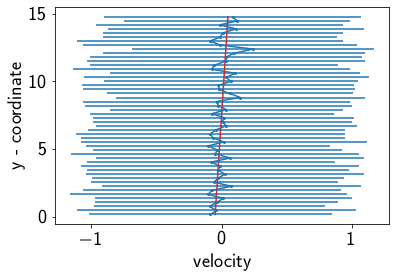

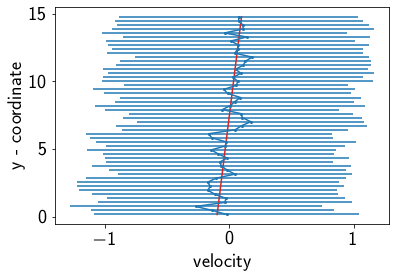

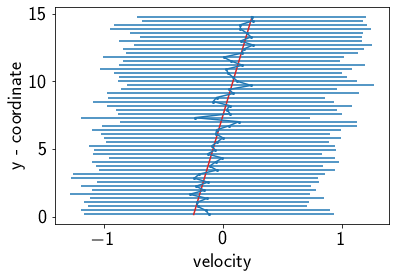

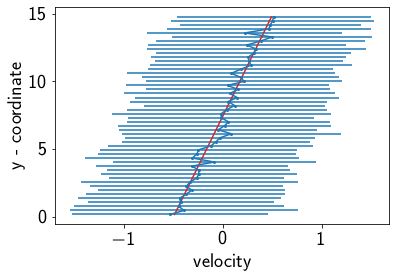

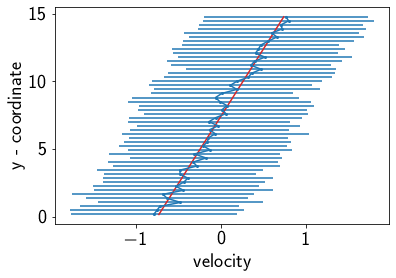

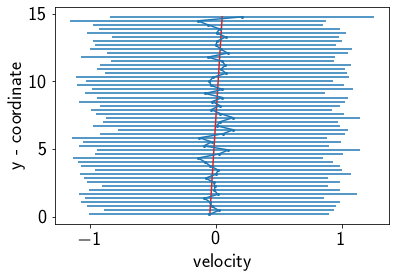

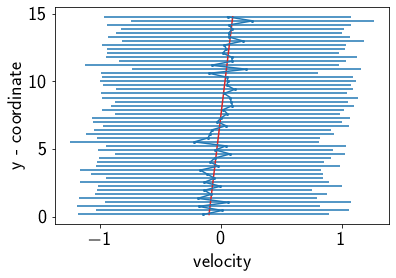

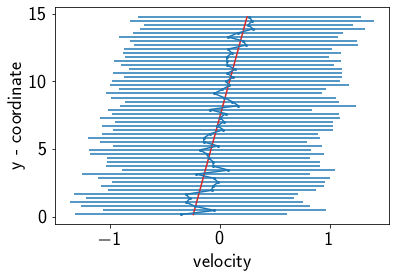

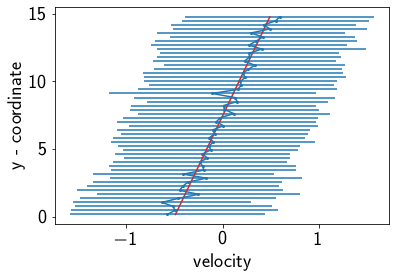

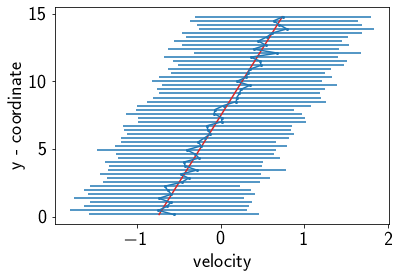

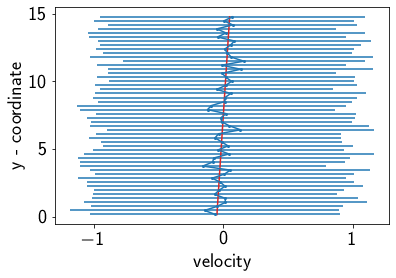

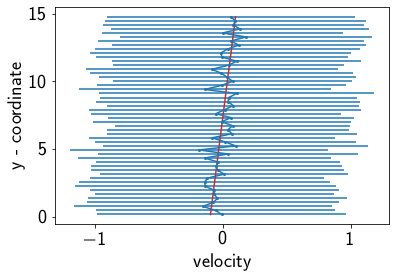

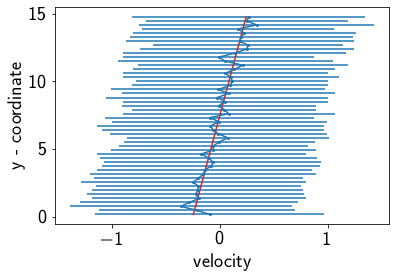

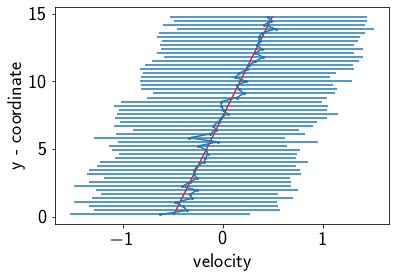

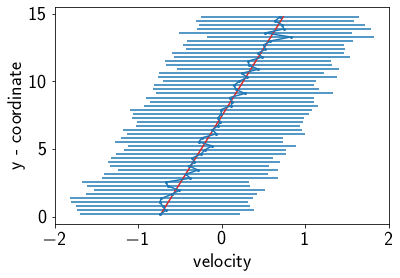

In [4]:
time = 1000
particles = 10000
boxsize = np.cbrt(particles/3)
number_of_bins = 51
bins = np.linspace(0.0, boxsize, number_of_bins)
bins_middle = np.empty([number_of_bins-1,1])

for a in range(number_of_bins-1):
    bins_middle[a] = 1/2 * (bins[a] + bins[a+1])

vels_temp = np.empty([number_of_bins-1,2])
vels = np.empty([number_of_bins-1,15])

run = 0

for job_name in job_names:
    for i in range(5):
        j = i+1

        with open('../parameter_files/params_dpd_vel.csv') as f:
            line = f.readlines()[j]
            line = line.split(',')
            
        shear_vel = float(line[0])
    
        print("Shear velocity:", shear_vel)
    
        h5file = h5py.File(data_dir + 'le_traj_' + job_name + '[' + str(j) +']/trajectory.h5', 'r')

        r = h5file['particles/atoms/position/value'][time]
        vel = h5file['particles/atoms/velocity/value'][time]
        image = h5file['particles/atoms/image/value'][time]
        le_offset = h5file['particles/atoms/lees_edwards_offset/value'][time]
        edges = h5file['particles/atoms/box/edges/'][:]
        r_time = h5file['particles/atoms/position/time'][time]
    
        pos = r + image*edges[None,None,:]
        pos[:,:,0] -= le_offset

        shear_rate = shear_vel / edges[1]
        print("Shear rate:", shear_rate)
        print("Time:", r_time)
    
        # Get trajectory of all particles and unwrap them
        # Add the LE offset

        for m in range(number_of_bins-1):
            
            vel_in_bin = []
            
            for n in range(particles):
                if pos[:, n, 1]%boxsize >= bins[m] and pos[:, n, 1]%boxsize < bins[m+1]:
                    vel_in_bin = np.append(vel_in_bin, vel[n, 0])         
            vels_temp[m,0] = np.mean(vel_in_bin)
            vels_temp[m,1] = np.std(vel_in_bin)
            
        plt.figure()
        plt.errorbar(vels_temp[:,0], bins_middle, xerr=vels_temp[:,1], marker='o', color="tab:blue", markersize='2', label="simulation")
        plt.plot(shear_vel * (bins_middle / edges[1] - 0.5), bins_middle, color="tab:red", label='prediction')
        plt.xlabel("velocity")
        plt.ylabel("y - coordinate")
        
        vels[:,run] = vels_temp[:,0]
        
        run += 1
    #print(vels_temp)

plt.show()

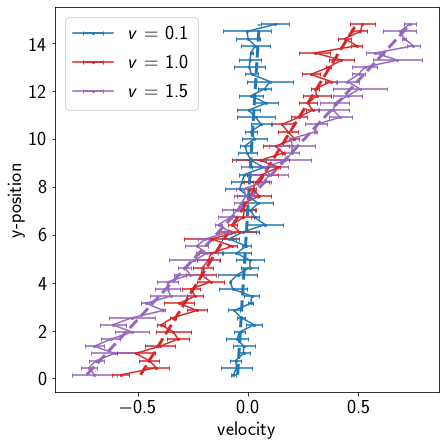

In [6]:
selection_base = np.array([0,5,10])
colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

plt.figure(figsize=(2*3.375,2*3.375))

for i in [0,3,4]:
    selection = selection_base + i
    j = i+1

    with open('../parameter_files/params_dpd_vel.csv') as f:
        line = f.readlines()[j]
        line = line.split(',')       
    shear_vel = float(line[0])
    
    mean = np.mean(vels[:,selection], axis=1)
    std = np.std(vels[:,selection], axis=1)
    #print(mean)
    #print(std)
   
    plt.errorbar(mean, bins_middle, xerr= std, marker='o', color=colors[i], markersize='2', label="$v$ = " + str(shear_vel), capsize=2, lw=1.5)
    plt.plot(shear_vel * (bins_middle / edges[1] - 0.5), bins_middle, color=colors[i], linestyle='--', lw=3.)
    
plt.legend()
plt.xlabel("velocity")
plt.ylabel("y-position")    
plt.tight_layout()
#plt.savefig("flowprofile.pdf")